![](https://www.pyimagesearch.com/wp-content/uploads/2017/12/not_santa_detector_dl_logos.jpg)
**This notebook attempts to tackle this classification problem by using Keras LSTM. While there are many notebook out there that are already tackling using this approach, I feel that there isn't enough explanation to what is going on each step. As someone who has been using vanilla Tensorflow, and recently embraced the wonderful world of Keras, I hope to share with fellow beginners the intuition that I gained from my research and study. **

We import the standard Keras library

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Loading the train and test files, as usual

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

A sneak peek at the training and testing dataset

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


A common preprocessing step is to check for nulls, and fill the null values with something before proceeding to the next steps. If you leave the null values intact, it will trip you up at the modelling stage later

In [4]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

Looks like we don't need to deal with the null values after all!

Note that: There are tons of preprocessing and feature engineering steps you could do for the dataset, but our focus today is not about the preprocessing task so what we are doing here is the minimal that could get the rest of the steps work well.

Movng on, as you can see from the sneak peek, the dependent variables are in the training set itself so we need to split them up, into X and Y sets.

This code defines a list of classes for a classification task related to toxic comments. It extracts the target variable (y) from the training data based on these classes. It also creates two lists of comment texts, one for the training set and another for the test set.





In [5]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

The approach that we are taking is to feed the comments into the LSTM as part of the neural network but we can't just feed the words as it is. 

So this is what we are going to do:
1. Tokenization - We need to break down the sentence into unique words. 
    For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
2. Indexing - We put the words in a dictionary-like structure and give them an index each
    For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
3. Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM.
    For eg, [1,2,3,4,2,5] 

Fortunately, Keras has made our lives so much easier. If you are using the vanilla Tensorflow, you probably need to implement your own dictionary structure and handle the indexing yourself. In Keras, all the above steps can be done in 4 lines of code. Note that we have to define the number of unique words in our dictionary when tokenizing the sentences.

This code sets a maximum number of features to use for tokenization and creates a tokenizer object. It fits the tokenizer on the training set's comment texts and tokenizes them into sequences. It also tokenizes the test set's comment texts into sequences using the same tokenizer.





In [6]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

Now, if you look at "list_tokenized_train", you will see that Keras has turned our words into index representation for us

In [7]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

But there's still 1 problem! What if some comments are terribly long, while some are just 1 word? Wouldn't our indexed-sentence look like this:
   
   Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]
  
  Comment #2: [1,2]

And we have to feed a stream of data that has a consistent length(fixed number of features) isn't it?

And this is why we use "padding"! We could make the shorter sentences as long as the others by filling the shortfall by zeros.But on the other hand, we also have to trim the longer ones to the same length(maxlen) as the short ones. In this case, we have set the max length to be 200.

This code sets the maximum length of sequences to 200 and pads the tokenized sequences of the training and test sets to ensure that they are of the same length. The resulting padded sequences are stored in variables X_t and X_te, respectively.





In [8]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

How do you know what is the best "maxlen" to set? If you put it too short, you might lose some useful feature that could cost you some accuracy points down the path.If you put it too long, your LSTM cell will have to be larger to store the possible values or states.

One of the ways to go about it is to see the distribution of the number of words in sentences.

This code calculates the total number of words in each comment of the tokenized training set and stores them in a list named 'totalNumWords'.





In [9]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

This code creates a histogram of the distribution of the total number of words in the comment texts of the training set. The histogram has bins of width 10, ranging from 0 to 400. The resulting histogram is displayed using matplotlib.





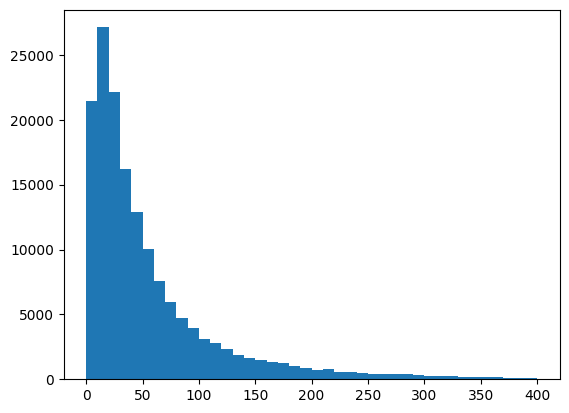

In [10]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

As we can see, most of the sentence length is about 30+. We could set the "maxlen" to about 50, but I'm being paranoid so I have set to 200. Then again, it sounds like something you could experiment and see what is the magic number.

**Finally the start of building our model!**

This is the architecture of the model we are trying to build. It's always to good idea to list out the dimensions of each layer in the model to think visually and help you to debug later on.
![](https://i.imgur.com/txJomEa.png)

As mentioned earlier, the inputs into our networks are our list of encoded sentences. We begin our defining an Input layer that accepts a list of sentences that has a dimension of 200.
![](https://i.imgur.com/uSjU4J7.png)
By indicating an empty space after comma, we are telling Keras to infer the number automatically.

This code defines an input layer for the neural network model, with a shape of (maxlen,), where maxlen is previously defined as 200.





In [11]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

Next, we pass it to our Embedding layer, where we project the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with, in the case of using one-hot encoding to represent the words in our sentence.
![](https://www.tensorflow.org/versions/r0.12/images/embedding-custom-projection.png)
The output of the Embedding layer is just a list of the coordinates of the words in this vector space. For eg. (-81.012) for "cat" and  (-80.012) for "dog". We could also use the distance of these coordinates to detect relevance and context. Embedding is a pretty deep topic, and if you are interested, this is a comprehensive guide: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

We need to define the size of the "vector space" we have mentioned above, and the number of unique words(max_features) we are using. Again, the embedding size is a parameter that you can tune and experiment.

This code sets the embedding size to 128 and creates an embedding layer with input dimension of max_features and output dimension of embed_size. The input to this layer is the previously defined input layer 'inp'.





In [12]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

The embedding layer outputs a 3-D tensor of (None, 200, 128). Which is an array of sentence(None means that it's size is inferred), and for each words(200), there is an array of 128 coordinates in the vector space of embedding. 

Next, we feed this Tensor into the LSTM layer. We set the LSTM to produce an output that has a dimension of 60 and want it to return the whole unrolled sequence of results.
As you probably know, LSTM or RNN works by recursively feeding the output of a previous network into the input of the current network, and you would take the final output after X number of recursion. But depending on use cases, you might want to take the unrolled, or the outputs of each recursion as the result to pass to the next layer. And this is the case.

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

From the above picture, the unrolled LSTM would give us a set of h0,h1,h2 until the last h.

From the short line of code that defines the LSTM layer, it's easy to miss the required input dimensions. LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs]. Batch size is the number of samples in a batch, time steps is the number of recursion it runs for each input, or it could be pictured as the number of "A"s in the above picture. Lastly, number of inputs is the number of variables(number of words in each sentence in our case) you pass into LSTM as pictured in "x" above.

We can make use of the output from the previous embedding layer which outputs a 3-D tensor of (None, 200, 128) into the LSTM layer. What it does is going through the samples, recursively run the LSTM model for 200 times, passing in the coordinates of the words each time. And because we want the unrolled version, we will receive a Tensor shape of (None, 200, 60), where 60 is the output dimension we have defined.

This code adds an LSTM layer with 60 units to the neural network model. The 'return_sequences' parameter is set to True, which means the output of this layer will have the same shape as its input. The layer is given the name 'lstm_layer'. The input to this layer is the output of the previously defined embedding layer.





In [13]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

Before we could pass the output to a normal layer, we need to reshape the 3D tensor into a 2D one. We reshape carefully to avoid throwing away data that is important to us, and ideally we want the resulting data to be a good representative of the original data.

Therefore, we use a Global Max Pooling layer which is traditionally used in CNN problems to reduce the dimensionality of image data. In simple terms, we go through each patch of data, and we take the maximum values of each patch. These collection of maximum values will be a new set of down-sized data we can use.

As you can see from other Kaggle kernels, different variants (Average,Max,etc) of pooling layers are used for dimensionality reduction and they could yield different results so do try them out. 

If you are interested in finding out the technical details of pooling, read up here: https://wiseodd.github.io/techblog/2016/07/18/convnet-maxpool-layer/


This code adds a global max pooling layer to the neural network model. This layer takes the maximum value of each feature map in the previous layer's output, resulting in a reduced feature map. The input to this layer is the output of the previously defined LSTM layer.





In [14]:
x = GlobalMaxPool1D()(x)

With a 2D Tensor in our hands, we pass it to a Dropout layer which indiscriminately "disable" some nodes so that the nodes in the next layer is forced to handle the representation of the missing data and the whole network could result in better generalization.
![](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_5/dropout.jpeg)

We set the dropout layer to drop out 10%(0.1) of the nodes.

This code adds a dropout layer to the neural network model, with a rate of 0.1. The dropout layer randomly sets 10% of the input to 0 during training, which helps to prevent overfitting. The input to this layer is the output of the previous global max pooling layer.





In [15]:
x = Dropout(0.1)(x)

After a drop out layer, we connect the output of drop out layer to a densely connected layer and the output passes through a RELU function. In short, this is what it does:

**Activation( (Input X Weights) + Bias)**

all in 1 line, with the weights, bias and activation layer all set up for you! 
We have defined the Dense layer to produce a output dimension of 50.

This code adds a dense layer with 50 units and ReLU activation function to the neural network model. The input to this layer is the output of the previous dropout layer.





In [16]:
x = Dense(50, activation="relu")(x)

We feed the output into a Dropout layer again.

This code adds another dropout layer to the neural network model, with a rate of 0.1. This layer randomly sets 10% of the input to 0 during training, which helps to prevent overfitting. The input to this layer is the output of the previous dense layer.





In [17]:
x = Dropout(0.1)(x)

Finally, we feed the output into a Sigmoid layer. The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.

This code adds the final dense layer to the neural network model, with 6 units and a sigmoid activation function. The sigmoid function maps the output values to probabilities between 0 and 1 for each class. The input to this layer is the output of the previous dropout layer.





In [18]:
x = Dense(6, activation="sigmoid")(x)

We are almost done! All is left is to define the inputs, outputs and configure the learning process. We have set our model to optimize our loss function using Adam optimizer, define the loss function to be "binary_crossentropy" since we are tackling a binary classification. In case you are looking for the learning rate, the default is set at 0.001.

This code creates the neural network model by defining its input and output layers, and compiles the model using the binary cross-entropy loss function, Adam optimizer, and accuracy metric. The 'Model' function is used to define the input and output layers, with 'inputs' and 'outputs' parameters specifying the layers. The compiled model is stored in a variable named 'model'.





In [19]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

The moment that we have been waiting for as arrived! It's finally time to put our model to the test. We'll feed in a list of 32 padded, indexed sentence for each batch and split 10% of the data as a validation set. This validation set will be used to assess whether the model has overfitted, for each batch. The model will also run for 2 epochs. These are some of the tunable parameters that you can experiment with, to see if you can push the accurate to the next level without crashing your machine(hence the batch size).

This code trains the neural network model using the fit function, with the training data and labels as inputs. The batch size is set to 32, and the number of epochs is set to 2. The validation split parameter is set to 0.1, which means 10% of the training data will be used for validation. The fit function updates the model parameters using backpropagation during each epoch and returns a history object containing the training and validation loss and accuracy.





In [20]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 929s 206ms/step - loss: 0.0679 - accuracy: 0.9562 - val_loss: 0.0499 - val_accuracy: 0.9939
Epoch 2/2
4488/4488 [==============================] - 910s 203ms/step - loss: 0.0449 - accuracy: 0.9796 - val_loss: 0.0480 - val_accuracy: 0.9938
